# 590 HW3

In [170]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords

import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, SpatialDropout1D, MaxPool1D, Conv1D,Conv2D,GlobalMaxPooling1D, MaxPooling2D, UpSampling2D,Dropout,Flatten, Embedding, LSTM
from keras.models import Model,Sequential
from keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16
from keras.preprocessing import sequence
from keras import regularizers
import keras
import tensorflow as tf

from keras.utils import np_utils, to_categorical 
from keras.datasets import cifar10
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, Adam, RMSprop

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.layers import SimpleRNN, LSTM, Embedding



## PROBLEM 1: AUTOCODER

In [7]:
# Load cifar10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalize training and testing data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [9]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [13]:
# input layer
input_img = keras.Input(shape=(32, 32, 3))  

# Convolutional autoencoder: 
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, kernel_size = (3, 3), activation='relu', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 8)         2312      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)          

In [14]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
391/391 [==============================] - 128s 326ms/step - loss: 0.6856 - accuracy: 0.3973 - val_loss: 0.6101 - val_accuracy: 0.4152
Epoch 2/10
391/391 [==============================] - 118s 301ms/step - loss: 0.6250 - accuracy: 0.4036 - val_loss: 0.6161 - val_accuracy: 0.4033
Epoch 3/10
391/391 [==============================] - 148s 379ms/step - loss: 0.6110 - accuracy: 0.4080 - val_loss: 0.6066 - val_accuracy: 0.4194
Epoch 4/10
391/391 [==============================] - 169s 433ms/step - loss: 0.6041 - accuracy: 0.4297 - val_loss: 0.6032 - val_accuracy: 0.4648
Epoch 5/10
391/391 [==============================] - 162s 414ms/step - loss: 0.6007 - accuracy: 0.4553 - val_loss: 0.5984 - val_accuracy: 0.4926
Epoch 6/10
391/391 [==============================] - 108s 276ms/step - loss: 0.6036 - accuracy: 0.4846 - val_loss: 0.5992 - val_accuracy: 0.4711
Epoch 7/10
391/391 [==============================] - 113s 288ms/step - loss: 0.5951 - accuracy: 0.5469 - val_loss: 0.5933 -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


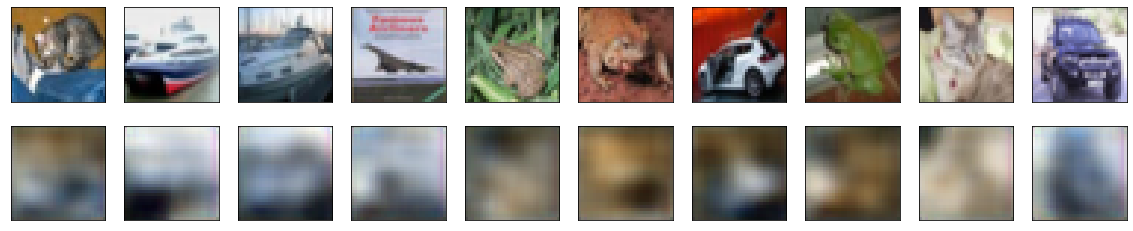

In [15]:
#decode image and visualize
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Problem 2.1 Deep CNN

In [19]:
tf.one_hot(y_train,10)


<tf.Tensor: shape=(50000, 1, 10), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [36]:
import tensorflow.keras as tfk
tfkl = tfk.layers

In [56]:
model = Sequential()
# block 1
model.add(tfkl.Conv2D(32,
                      (3,3),
                      strides=1,
                      input_shape=(32,32,3),
                      padding='valid',
                      activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.3))

# block 2
model.add(tfkl.Conv2D(32,
                      (3,3),
                      strides=1,
                      padding='valid',
                      activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.3))
model.add(tfkl.Flatten())
# block 3
model.add(tfkl.Dense(64,activation='relu'))
model.add(tfkl.Dropout(0.5))
model.add(tfkl.Dense(10,activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1152)            

In [57]:
# compile model
model.compile(optimizer=tfk.optimizers.RMSprop(),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [58]:
train_label = to_categorical(y_train)
test_label = to_categorical(y_test)
results = model.fit(x_train,
                      train_label,
                      steps_per_epoch=100,
                      epochs=20, 
                      batch_size=16,
                      validation_data=(x_test,test_label))

Epoch 1/20
100/100 [==============================] - 6s 63ms/step - loss: 2.2976 - accuracy: 0.1306 - val_loss: 2.2570 - val_accuracy: 0.1980
Epoch 2/20
100/100 [==============================] - 5s 51ms/step - loss: 2.2029 - accuracy: 0.1606 - val_loss: 2.1534 - val_accuracy: 0.1870
Epoch 3/20
100/100 [==============================] - 6s 60ms/step - loss: 2.1351 - accuracy: 0.2138 - val_loss: 2.0494 - val_accuracy: 0.2309
Epoch 4/20
100/100 [==============================] - 4s 43ms/step - loss: 2.1080 - accuracy: 0.2219 - val_loss: 1.9947 - val_accuracy: 0.2772
Epoch 5/20
100/100 [==============================] - 4s 45ms/step - loss: 2.0257 - accuracy: 0.2494 - val_loss: 2.0149 - val_accuracy: 0.2679
Epoch 6/20
100/100 [==============================] - 4s 43ms/step - loss: 1.9805 - accuracy: 0.2625 - val_loss: 1.8916 - val_accuracy: 0.3253
Epoch 7/20
100/100 [==============================] - 4s 42ms/step - loss: 1.9334 - accuracy: 0.2744 - val_loss: 1.8579 - val_accuracy: 0.3313

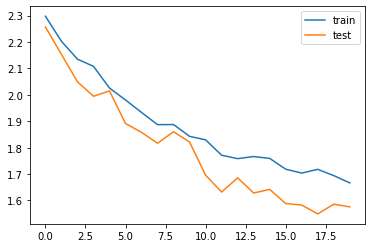

In [59]:
# Plot the test and train results
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(labels=['train','test'])

## Problem 2.2 Transfer Learning

In [60]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [62]:
# train model
model = Sequential()
model.add(conv_base)
model.add(tfkl.Flatten())
model.add(tfkl.Dense(32, 
                      activation='relu'))
model.add(tfkl.Dropout(0.5))
model.add(tfkl.Dense(10, 
                      activation='softmax'))
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_21 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_46 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
Total params: 14,731,434
Trainable params: 14,731,434
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(optimizer=tfk.optimizers.RMSprop(),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [69]:
results = model.fit(x_train, 
                      train_label, 
                      epochs=5, 
                      batch_size=32,
                      validation_data=(x_test,test_label))

Epoch 1/5
1563/1563 [==============================] - 481s 308ms/step - loss: 1.8225 - accuracy: 0.3448 - val_loss: 1.4580 - val_accuracy: 0.5079
Epoch 2/5
1563/1563 [==============================] - 545s 349ms/step - loss: 1.5982 - accuracy: 0.4344 - val_loss: 1.3666 - val_accuracy: 0.5287
Epoch 3/5
1563/1563 [==============================] - 466s 298ms/step - loss: 1.5531 - accuracy: 0.4522 - val_loss: 1.3431 - val_accuracy: 0.5364
Epoch 4/5
1563/1563 [==============================] - 444s 284ms/step - loss: 1.5243 - accuracy: 0.4661 - val_loss: 1.3362 - val_accuracy: 0.5419
Epoch 5/5
1563/1563 [==============================] - 506s 324ms/step - loss: 1.5138 - accuracy: 0.4735 - val_loss: 1.3304 - val_accuracy: 0.5409


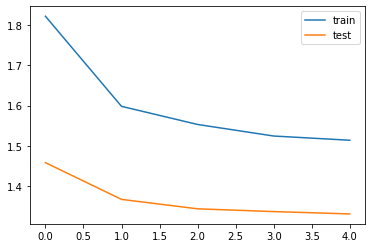

In [71]:
# plot loss for train and test
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(labels=['train','test'])

## Problem 3.Text Classification
### 3.1 RNN

In [158]:
spam = pd.read_csv('./desktop/SPAM_detection.csv')
spam.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [159]:
x = spam['Message'].values
y = spam['category_val'].values

In [161]:
# data preprocessing
# tokenize data
# transform to sequences
tok = Tokenizer()
tok.fit_on_texts(x)
x = tok.texts_to_sequences(x)
x = sequence.pad_sequences(x)

In [149]:
import sklearn

In [162]:
# split data to train and test
x_train, x_test, y_train, y_test  = sklearn.model_selection.train_test_split(x, y, test_size=0.3)

In [163]:
## RNN with LSTM
model = tfk.Sequential()
model.add(tfkl.Embedding(len(tokenizer.word_index)+1, 32, input_length=40))
model.add(tfkl.LSTM(128,return_sequences=True))
# reduce dimension
model.add(tfkl.GlobalMaxPool1D())
model.add(tfkl.Dropout(0.4))

model.add(tfkl.Dense(64,activation="relu"))
model.add(tfkl.Dropout(0.4))

model.add(tfkl.Dense(1,activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.01),metrics=['accuracy'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 32)            288160    
_________________________________________________________________
lstm_7 (LSTM)                (None, 40, 128)           82432     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_57 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [164]:
model.fit(x_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(x_test,y_test))

Epoch 1/10
122/122 [==============================] - 46s 378ms/step - loss: 0.2492 - accuracy: 0.9236 - val_loss: 0.1140 - val_accuracy: 0.9629
Epoch 2/10
122/122 [==============================] - 54s 443ms/step - loss: 0.0577 - accuracy: 0.9849 - val_loss: 0.0480 - val_accuracy: 0.9856
Epoch 3/10
122/122 [==============================] - 51s 417ms/step - loss: 0.0386 - accuracy: 0.9949 - val_loss: 0.0606 - val_accuracy: 0.9874
Epoch 4/10
122/122 [==============================] - 36s 292ms/step - loss: 0.0231 - accuracy: 0.9959 - val_loss: 0.0673 - val_accuracy: 0.9874
Epoch 5/10
122/122 [==============================] - 37s 306ms/step - loss: 0.0102 - accuracy: 0.9979 - val_loss: 0.1386 - val_accuracy: 0.9862
Epoch 6/10
122/122 [==============================] - 47s 387ms/step - loss: 0.0259 - accuracy: 0.9954 - val_loss: 0.1957 - val_accuracy: 0.9827
Epoch 7/10
122/122 [==============================] - 48s 392ms/step - loss: 1.6744e-04 - accuracy: 1.0000 - val_loss: 0.2156 - va

In [166]:
# calculation for ROC viz
y_rnn_pred = model.predict(x_test)
fpr_rnn, tpr_rnn, rnn_ = roc_curve(y_test, y_rnn_pred)
auc_rnn = auc(fpr_rnn, tpr_rnn)
auc_rnn

0.9862488026819923

In [210]:
# split data to train and test for CNN
x_train, x_test, y_train, y_test  = sklearn.model_selection.train_test_split(x, y, test_size=0.2)

In [185]:
x_train.shape

(4457, 189)

In [186]:
y_train.shape

(4457,)

In [208]:
# cnn model fitting
model_cnn = tfk.Sequential([
  # relu fucntion
  tfkl.Conv1D(filters= 200,
              kernel_size=2,
              strides=1,
              activation='relu',
              padding='same',
              input_shape=(x_train.shape[1],1)),
  tfkl.MaxPooling1D(pool_size=2,
                    padding='same'),
  tfkl.Conv1D(filters = 128, 
              kernel_size=2,
              strides=1,
              activation='relu',
              padding='same'),
  tfkl.Dropout(0.3),
  tfkl.Conv1D(32,
              kernel_size=2,
              strides=1,
              activation='relu',
              padding='same'),
  tfkl.Flatten(),
  tfkl.Dense(16,
             activation='relu'),
  tfkl.Dense(1,
             activation='sigmoid')                     
])
model_cnn.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 189, 200)          600       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 95, 200)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 95, 128)           51328     
_________________________________________________________________
dropout_63 (Dropout)         (None, 95, 128)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 95, 32)            8224      
_________________________________________________________________
flatten_29 (Flatten)         (None, 3040)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)              

In [214]:
# compile model
model_cnn.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
# fit cnn model
model_cnn.fit(x_train,
              y_train,
              epochs = 10,
              batch_size = 32,
              validation_data=(x_test,y_test))

Epoch 1/10
140/140 [==============================] - 16s 111ms/step - loss: 1.2599 - accuracy: 0.8454 - val_loss: 0.3155 - val_accuracy: 0.8601
Epoch 2/10
140/140 [==============================] - 11s 78ms/step - loss: 0.3287 - accuracy: 0.8670 - val_loss: 0.2827 - val_accuracy: 0.8601
Epoch 3/10
140/140 [==============================] - 9s 66ms/step - loss: 0.2932 - accuracy: 0.8672 - val_loss: 0.2750 - val_accuracy: 0.8601
Epoch 4/10
140/140 [==============================] - 11s 77ms/step - loss: 0.2907 - accuracy: 0.8674 - val_loss: 0.2727 - val_accuracy: 0.8601
Epoch 5/10
140/140 [==============================] - 10s 72ms/step - loss: 0.2923 - accuracy: 0.8674 - val_loss: 0.2695 - val_accuracy: 0.8601
Epoch 6/10
140/140 [==============================] - 11s 79ms/step - loss: 0.2801 - accuracy: 0.8674 - val_loss: 0.2668 - val_accuracy: 0.8601
Epoch 7/10
140/140 [==============================] - 12s 84ms/step - loss: 0.2777 - accuracy: 0.8674 - val_loss: 0.4479 - val_accuracy:

In [215]:
# predict cnn x_test
y_cnn_pred = model_cnn.predict(x_test)

In [216]:
# cnn metreics for ROC
fpr_cnn, tpr_cnn, cnn_ = roc_curve(y_test, y_cnn_pred)
auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_cnn

0.8848292826395017

## Problem 3.3 ROC

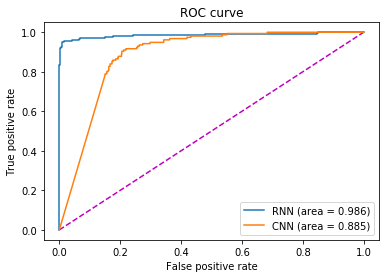

In [217]:
plt.figure()
plt.plot([0, 1], [0, 1], 'm--')
plt.plot(fpr_rnn, tpr_rnn, label='RNN (area = {:.3f})'.format(auc_rnn))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc = 'lower right')

plt.show()